<a href="https://colab.research.google.com/github/ananyas168/GNN/blob/main/node_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! nvcc --version 

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [ ]:
!pip install dgl-cu110 
%matplotlib inline
!pip install scikit-plot
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report,confusion_matrix
import scikitplot as skplt

     |████████████████████████████████| 39.9MB 139kB/s 
Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


In [ ]:
import dgl.data

dataset = dgl.data.CoraGraphDataset()
print('Number of categories:', dataset.num_classes)
g = dataset[0]
print(g)
# k= dataset[1]
# print(k)
print('Node features')
print(g.ndata)
print('Edge features')
print(g.edata)


Extracting file to /root/.dgl/cora_v2
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.
Number of categories: 7
Graph(num_nodes=2708, num_edges=10556,
      ndata_schemes={'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'label': Scheme(shape=(), dtype=torch.int64), 'feat': Scheme(shape=(1433,), dtype=torch.float32)}
      edata_schemes={})
Node features
{'train_mask': tensor([ True,  True,  True,  ..., False, False, False]), 'val_mask': tensor([False, False, False,  ..., False, False, False]), 'test_mask': tensor([False, False, False,  ...,  True,  True,  True]), 'label': tensor([3, 4, 4,  ..., 3, 3, 3]), 'feat': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0

#Graph Convolution Model

In [ ]:
from dgl.nn import GraphConv
import pandas as pd
print(g.ndata['feat'].shape)
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)
        #self.conv3 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

# Create the model with given dimensions
model2 = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes) # shape[1] because we need to know how mant feature are assosiated in a node embedding vector(here = 1433)

torch.Size([2708, 1433])


In [ ]:
#model.summary

In epoch 0, loss: 1.946, val acc: 0.080 (best 0.080), test acc: 0.097 (best 0.097)
In epoch 5, loss: 1.905, val acc: 0.366 (best 0.366), test acc: 0.387 (best 0.387)
In epoch 10, loss: 1.833, val acc: 0.508 (best 0.508), test acc: 0.520 (best 0.520)
In epoch 15, loss: 1.737, val acc: 0.608 (best 0.608), test acc: 0.615 (best 0.615)
In epoch 20, loss: 1.616, val acc: 0.622 (best 0.628), test acc: 0.639 (best 0.634)
In epoch 25, loss: 1.473, val acc: 0.634 (best 0.634), test acc: 0.652 (best 0.652)
In epoch 30, loss: 1.312, val acc: 0.650 (best 0.650), test acc: 0.670 (best 0.663)
In epoch 35, loss: 1.141, val acc: 0.660 (best 0.660), test acc: 0.677 (best 0.676)
In epoch 40, loss: 0.970, val acc: 0.676 (best 0.676), test acc: 0.691 (best 0.691)
In epoch 45, loss: 0.808, val acc: 0.698 (best 0.698), test acc: 0.710 (best 0.710)
In epoch 50, loss: 0.662, val acc: 0.726 (best 0.726), test acc: 0.732 (best 0.732)
In epoch 55, loss: 0.537, val acc: 0.732 (best 0.732), test acc: 0.742 (best 0

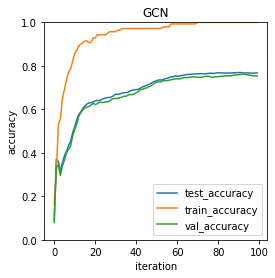

In [ ]:
def train(g, model,path):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0
    best_test_acc = 0
    val=[]
    test=[]
    train=[]

    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']
    for e in range(100):
        # Forward
        logits = model(g, features)
        #print('logits are:',logits)
        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()
        #print(test_acc.item())
        test.append(test_acc.item())
        train.append(train_acc.item())
        val.append(val_acc.item())
        


        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0:
            print('In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(
                e, loss, val_acc, best_val_acc, test_acc, best_test_acc))
    #prediction, index = torch.max(pred[test_mask],1) 
    # print(pred[test_mask])
    # print(labels[test_mask])
    # #print(index)       
    # print("f1 score:{}\n".format(f1_score(labels[test_mask],pred[test_mask])))
    
    # print('confusion matrix')
    # skplt.metrics.plot_confusion_matrix(labels[test_mask],pred[test_mask]) 
    df= pd.DataFrame()
    df['test_accuracy']= test
    df['train_accuracy'] = train
    df['val_accuracy'] = val
    print(df)
    ax = df.plot.line(rot=0,ylim=(0,1),figsize=[4,4],title= path)#,colormap='flare')
    #ax = bar_data.plot.bar(rot=0)
    #ax.label_outer('comparative_accuracy_bar_plot')
    fig=ax.get_figure()
    fig.savefig(path)
    ax.set_xlabel("iteration")
    ax.set_ylabel("accuracy")
g = g.to('cuda')
model2 = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes).to('cuda')
train(g, model2, 'GCN')            
# model2 = GCN(g.ndata['feat'].shape[1], 16,32, dataset.num_classes)
# train(g, model2)

#Graph Sage Model

In [ ]:
import dgl.function as fn

class SAGEConv(nn.Module):
    """Graph convolution module used by the GraphSAGE model.

    Parameters
    ----------
    in_feat : int
        Input feature size.
    out_feat : int
        Output feature size.
    """
    def __init__(self, in_feat, out_feat):
        super(SAGEConv, self).__init__()
        # A linear submodule for projecting the input and neighbor feature to the output.
        self.linear = nn.Linear(in_feat * 2, out_feat)

    def forward(self, g, h):
        """Forward computation

        Parameters
        ----------
        g : Graph
            The input graph.
        h : Tensor
            The input node feature.
        """
        with g.local_scope():
            g.ndata['h'] = h
            # update_all is a message passing API.
            g.update_all(message_func=fn.copy_u('h', 'm'), reduce_func=fn.mean('m', 'h_N'))
            h_N = g.ndata['h_N']
            h_total = torch.cat([h, h_N], dim=1)
            return self.linear(h_total)

In epoch 0, loss: 1.949, val acc: 0.114 (best 0.114), test acc: 0.103 (best 0.103)
In epoch 5, loss: 1.882, val acc: 0.200 (best 0.200), test acc: 0.232 (best 0.232)
In epoch 10, loss: 1.754, val acc: 0.574 (best 0.584), test acc: 0.556 (best 0.568)
In epoch 15, loss: 1.555, val acc: 0.614 (best 0.614), test acc: 0.618 (best 0.618)
In epoch 20, loss: 1.287, val acc: 0.652 (best 0.652), test acc: 0.645 (best 0.645)
In epoch 25, loss: 0.985, val acc: 0.672 (best 0.672), test acc: 0.671 (best 0.671)
In epoch 30, loss: 0.692, val acc: 0.728 (best 0.728), test acc: 0.729 (best 0.729)
In epoch 35, loss: 0.448, val acc: 0.756 (best 0.756), test acc: 0.752 (best 0.747)
In epoch 40, loss: 0.274, val acc: 0.754 (best 0.762), test acc: 0.762 (best 0.756)
In epoch 45, loss: 0.165, val acc: 0.762 (best 0.764), test acc: 0.764 (best 0.763)
In epoch 50, loss: 0.100, val acc: 0.762 (best 0.764), test acc: 0.765 (best 0.763)
In epoch 55, loss: 0.064, val acc: 0.762 (best 0.764), test acc: 0.766 (best 0

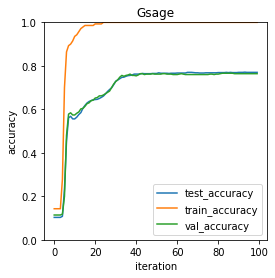

In [ ]:
class GSage(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GSage, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats)
        self.conv2 = SAGEConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h
g = g.to('cuda')
model = GSage(g.ndata['feat'].shape[1], 16, dataset.num_classes).to('cuda')
train(g, model,'Gsage')        

# Weighted Graph Convolution Model

In [ ]:
class WeightedSAGEConv(nn.Module):
    """Graph convolution module used by the GraphSAGE model with edge weights.

    Parameters
    ----------
    in_feat : int
        Input feature size.
    out_feat : int
        Output feature size.
    """
    def __init__(self, in_feat, out_feat):
        super(WeightedSAGEConv, self).__init__()
        # A linear submodule for projecting the input and neighbor feature to the output.
        self.linear = nn.Linear(in_feat * 2, out_feat)

    def forward(self, g, h, w):
        """Forward computation

        Parameters
        ----------
        g : Graph
            The input graph.
        h : Tensor
            The input node feature.
        w : Tensor
            The edge weight.
        """
        with g.local_scope():
            g.ndata['h'] = h
            g.edata['w'] = w
            g.update_all(message_func=fn.u_mul_e('h', 'w', 'm'), reduce_func=fn.mean('m', 'h_N'))
            h_N = g.ndata['h_N']
            h_total = torch.cat([h, h_N], dim=1)
            return self.linear(h_total)

In epoch 0, loss: 1.949, val acc: 0.156 (best 0.156), test acc: 0.144 (best 0.144)
In epoch 5, loss: 1.854, val acc: 0.480 (best 0.588), test acc: 0.488 (best 0.595)
In epoch 10, loss: 1.688, val acc: 0.550 (best 0.588), test acc: 0.563 (best 0.595)
In epoch 15, loss: 1.446, val acc: 0.638 (best 0.638), test acc: 0.645 (best 0.645)
In epoch 20, loss: 1.144, val acc: 0.696 (best 0.696), test acc: 0.711 (best 0.711)
In epoch 25, loss: 0.824, val acc: 0.720 (best 0.720), test acc: 0.739 (best 0.739)
In epoch 30, loss: 0.535, val acc: 0.738 (best 0.738), test acc: 0.752 (best 0.751)
In epoch 35, loss: 0.319, val acc: 0.754 (best 0.754), test acc: 0.763 (best 0.763)
In epoch 40, loss: 0.183, val acc: 0.758 (best 0.760), test acc: 0.772 (best 0.768)
In epoch 45, loss: 0.106, val acc: 0.762 (best 0.762), test acc: 0.782 (best 0.782)
In epoch 50, loss: 0.065, val acc: 0.768 (best 0.770), test acc: 0.782 (best 0.783)
In epoch 55, loss: 0.042, val acc: 0.764 (best 0.770), test acc: 0.780 (best 0

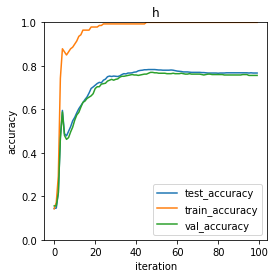

In [ ]:
class WeightedGSage(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(WeightedGSage, self).__init__()
        self.conv1 = WeightedSAGEConv(in_feats, h_feats)
        self.conv2 = WeightedSAGEConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat, torch.ones(g.num_edges()).to(g.device))
        h = F.relu(h)
        h = self.conv2(g, h, torch.ones(g.num_edges()).to(g.device))
        return h

model = WeightedGSage(g.ndata['feat'].shape[1], 16, dataset.num_classes).to('cuda')
train(g, model,'h')

#Graph attention Model

In epoch 0, loss: 1.945, val acc: 0.200 (best 0.200), test acc: 0.211 (best 0.211)
In epoch 5, loss: 1.487, val acc: 0.784 (best 0.784), test acc: 0.779 (best 0.779)
In epoch 10, loss: 0.917, val acc: 0.780 (best 0.784), test acc: 0.782 (best 0.779)
In epoch 15, loss: 0.440, val acc: 0.782 (best 0.788), test acc: 0.788 (best 0.791)
In epoch 20, loss: 0.182, val acc: 0.786 (best 0.788), test acc: 0.800 (best 0.791)
In epoch 25, loss: 0.073, val acc: 0.770 (best 0.788), test acc: 0.804 (best 0.791)
In epoch 30, loss: 0.031, val acc: 0.772 (best 0.788), test acc: 0.796 (best 0.791)
In epoch 35, loss: 0.015, val acc: 0.762 (best 0.788), test acc: 0.790 (best 0.791)
In epoch 40, loss: 0.008, val acc: 0.760 (best 0.788), test acc: 0.784 (best 0.791)
In epoch 45, loss: 0.005, val acc: 0.756 (best 0.788), test acc: 0.781 (best 0.791)
In epoch 50, loss: 0.003, val acc: 0.752 (best 0.788), test acc: 0.782 (best 0.791)
In epoch 55, loss: 0.002, val acc: 0.752 (best 0.788), test acc: 0.778 (best 0

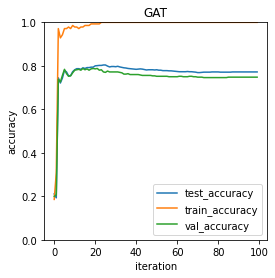

In [ ]:

from dgl.nn.pytorch.conv import GATConv

class GAT(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_heads):
        super(GAT, self).__init__()
        self.layer1 = GATConv(in_dim, hidden_dim, num_heads)
        self.layer2 = GATConv(hidden_dim * num_heads, out_dim, 1)
    def forward(self, g, h):
        h = self.layer1(g, h)
        h = h.view(-1, h.size(1) * h.size(2))
        h = F.elu(h)
        h = self.layer2(g, h)
        h = h.squeeze() 
        return h

model = GAT(g.ndata['feat'].shape[1], 16, dataset.num_classes,12).to('cuda')
train(g, model,'GAT')        